# 1.3 Finite Difference Method - Composite Wall

Prepared by (C) Vasken Dermardiros

In this section, we will be looking at a composite wall. The interior and exterior conditions are fixed. The wall is initialized at a fixed temperature, but in the end, we would like to determine the heat loss to the exterior at steady state conditions.  
Using the equations introduced in Chapter 1.1, we will calculate the temperature within a uniform wall using both Implicit and Explicit schemes.

## Problem Statement
A composite wall is subjected to the following conditions:  
$h_{conv,int} = 10 W/m^2K, T_{int} = 20°C$  
$h_{conv,ext} = 30 W/m^2K, T_{ext} = -20°C$  

The wall is initialized at 20°C. It consists of the following layers from outside to inside:  
1) Exterior air film  
2) 75 mm brick  
3) 25 mm air gap  
4) 15 mm plywood  
5) 150 mm fiberglass insulation  
6) 15 mm gypsumboard  
7) Interior air film

The material properties are given in the script.

------------
## FDM Implementation
### Load Dependencies

In [46]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
# Plot in notebook; comment out the line below for windowed plots
%matplotlib inline
# mpl.rc('figure', figsize=(10, 10))

### Variable Names
Uin: Conductance matrix input by user, upper triangle only, (nN x nN) (W/K)  
U: Conductance matrix (symmetrical) with added capacitance for diagonal term, (nN x nN) (W/K)  
C: Capacitance vector, (nN x 1) (J/K)  
F: Conductance matrix of nodes connected to a known temperature source, (nN x nM) (W/K)  
T: Temperature vector per timestep, (nT x nN) (degC)  
TK: Temperature vector of known temperatures per timestep, (nT x nM) (degC)  
Qin: Heat flow, only external sources, (nN x 1) (W)  
Q: Heat flow vector + external sources + capacitance from previous timestep (implicit only), (nN x 1) (W)  
  
nN: Number of nodes  
nM: Number of nodes with known temperatures  
nT: Number of timesteps  

Node Number: Object  
0: exterior brick half  
1: between interior brick half & 25 mm air gap exterior side  
2: between air gap interior side & plywood half  
3: between plywood half & insulation  
4: between insulation & gypsum  
5: gypsum interior surface  
  
Node Number with known temperatures: Object  
0: exterior air  
1: interior air

In [47]:
# Number of nodes
nN = 6
nM = 2

# Wall Properties
A = 1.              # m^2, wall area

# Brick
dx_brick = 0.075
cp_brick = 900.
rho_brick = 1920.
k_brick = 1.

# Air Gap
R_gap = 0.17        # m^2K/W

# Plywood
dx_ply = 0.015
cp_ply = 2500.
rho_ply = 650.
k_ply = 0.13

# Fiberglass (negligeable capacitance)
dx_fiber = 0.150
k_fiber = 0.04

# Gypsumboard
dx_gypsum = 0.015
cp_gypsum = 1090.
rho_gypsum = 2300.
k_gypsum = 0.17

# Boundaries
h_conv_int = 10. # W/m^2K, convective heat transfer coefficient
T_int = 20.      # °C
h_conv_ext = 30. # W/m^2K, convective heat transfer coefficient
T_ext = -20.     # °C

### Simulation Parameters

In [48]:
st = 20         # steps per hour
H = 24          # hr; number of hours simulated
nt = int(st*H)  # number of timesteps-1
dt = 3600/st    # s (3600 sec = 1 hour), timestep

### Nodal Connections
This is what differenciates the models from one another: how are the nodes connected to each other? What is the conductance in between? How much thermal capacitance do the nodes have?

In [49]:
# Declare variables
Uin = np.zeros((nN,nN))     # K/W
F = np.zeros((nN,nM))       # K/W
C = np.zeros((nN,1))        # J/K

# How are the nodes connected?
Uin[0,1] = (dx_brick/(k_brick*A))**-1   # brick
Uin[1,2] = (R_gap/A)**-1                # air gap
Uin[2,3] = (dx_ply/(k_ply*A))**-1       # plywood
Uin[3,4] = (dx_fiber/(k_fiber*A))**-1   # fiberglass
Uin[4,5] = (dx_gypsum/(k_gypsum*A))**-1 # gypsumboard

# Connected to temperature sources
F[0,0] = (1/(h_conv_ext*A))**-1         # brick to exterior air
F[-1,1] = (1/(h_conv_int*A))**-1        # gypsum to interior air

# Nodes with capacitance: rho*cp*volume
C[0] = rho_brick*cp_brick*(dx_brick/2*A)    # half brick
C[1] = rho_brick*cp_brick*(dx_brick/2*A)    # half brick
C[2] = rho_ply*cp_ply*(dx_ply/2*A)          # half plywood
C[3] = rho_ply*cp_ply*(dx_ply/2*A)          # half plywood, fiberglass has negligible capacitance
C[4] = rho_gypsum*cp_gypsum*(dx_gypsum/2*A) # half gypsum
C[5] = rho_gypsum*cp_gypsum*(dx_gypsum/2*A) # half gypsum

### Temperatures and Known Temperatures

In [50]:
# Declare variables
T = np.zeros((nt, nN))    # degC
TK = np.zeros((nt, nM))   # degC

# Known temperature sources
TK[:, 0] = T_ext          # exterior temperature
TK[:, 1] = T_int          # interior temperature

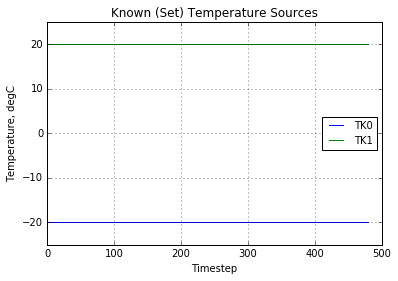

In [51]:
# Plot known temperature sources
fig = plt.figure()
plt.plot(TK)
labels = ['TK' + str(n) for n in range(nM)]
plt.legend(labels,loc='best', fontsize='medium')
plt.ylim((-25, 25))
plt.xlabel('Timestep')
plt.ylabel('Temperature, degC')
plt.title('Known (Set) Temperature Sources')
plt.grid()
plt.show()

### Initial Conditions

In [52]:
T[0,] = 20.      # all temperatures set to 20 degC

------------
## Run Simulation (Implicit Scheme)
Ideally, we should be able to reuse this part of the code applying only minimal changes. For cases where materials properties change over time or due to temperature, or when controls are present, the U-matrix completion should be done within the Main Loop.

### U-matrix completion

In [53]:
# Here, we complete the connections due to symmetry 
# Node 0 is connected to node 1; also, node 1 is connected to node 0.
U = -Uin - Uin.T  # U is symmetrical, non-diagonals are -ve
s = -np.sum(U,1)
for i in range(0,nN):
    U[i,i] = s[i] + np.sum(F[i,]) + C[i]/dt
del s

### Main Loop

In [54]:
# Loop for all timesteps
for t in range(0,nt-1):

    # Heat flow into the node, external sources
    Qin = np.zeros((nN,1))
    # Qin[0] = q_in # add heat sources here

    # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
    Q = Qin + np.reshape(np.dot(F, TK[t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[t,],(nN,1)))

    # Compute temperature
    # This is where the magic happens. For a system where nothing changes 
    # (no controls, no moveable blinds, no PCM; we need only define the 
    # U-matrix once (done above) and use it here)
    T[t+1,] = np.linalg.solve(U, Q).T

### Plotting

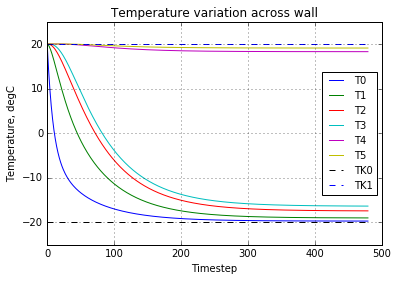

In [55]:
fig = plt.figure()
plt.plot(T)
plt.hold(True)
plt.plot(TK, '--')
labels = ['T' + str(n) for n in range(nN)] + ['TK' + str(m) for m in range(nM)]
plt.legend(labels,loc='best', fontsize='medium')
plt.ylim((-25, 25))
plt.xlabel('Timestep')
plt.ylabel('Temperature, degC')
plt.title('Temperature variation across wall')
plt.grid()
plt.show()

### Heat Loss through Wall

In [56]:
# Assuming the process has reached steady state conditions at the end of the simulation
# we would like to determine the heat loss through the wall.
Q_lost = F[0,0]*(T_ext-T[-1,0])
print "Heat gain or lost through the wall: %.2f W/m^2" % (Q_lost/A)

Heat gain or lost through the wall: -9.45 W/m^2


------------
## Run Simulation (Explicit Scheme)

In [57]:
# Declare variables
Te = np.zeros((nt,nN))  # degC, temperatures for explicit mode
Te[0,] = T[0,]          # initial condition set to be the same as implicit case

# RHS matrix
Ue = Uin + Uin.T
s = -np.sum(Ue,1)
for i in range(0,nN):
    Ue[i,i] = s[i] - np.sum(F[i,]) + C[i]/dt
del s
Und = Uin + Uin.T       # Without the diagonals

### Main Loop

In [58]:
# Loop for all timesteps in a day
for t in range(0,nt-1):

    # Heat flow into the node
    Qin = np.zeros((nN,1))
    # Qin[0] = q_in # add heat sources here

    # Q-vector (explicit): Q = Qin + F*TM(t)
    Q = Qin + np.reshape(np.dot(F, TK[t,]),(nN,1))

    # Compute temperature
    # This is where the magic happens. Prepare to be amazed!
    for c in range(nN):

        # Nodes with capacitance (diffusion nodes)
        if (C[c] != 0.):
            Te[t+1,c] = dt/C[c] * (np.dot(Ue[c,],Te[t,]) + Q[c])

        # Nodes without capacitance (arithmetic nodes)
        else:
            Te[t+1,c] = (np.dot(Und[c,],Te[t,]) + np.dot(F[c,],TK[t,]) + Qin[c]) \
                        / (np.sum(Und[c,]) + np.sum(F[c,]))

### Plotting

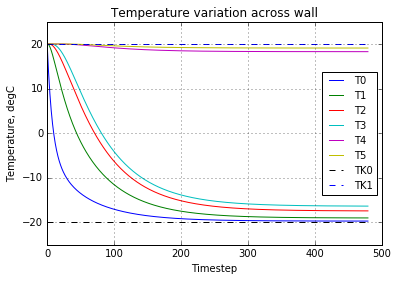

In [59]:
fig = plt.figure()
plt.plot(Te)
plt.hold(True)
plt.plot(TK, '--')
labels = ['T' + str(n) for n in range(nN)] + ['TK' + str(m) for m in range(nM)]
plt.legend(labels,loc='best', fontsize='medium')
plt.ylim((-25, 25))
plt.xlabel('Timestep')
plt.ylabel('Temperature, degC')
plt.title('Temperature variation across wall')
plt.grid()
plt.show()